## Importing Python libraries

In [2]:
import numpy as np
import mpctools as mpc
import mpctools.plots as mpcplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import control as ctrl

## Defining the continous and discrete state space representations

In [3]:
# Define continuous time model.
Acont = np.array([[-1.2822, 0, 0.98, 0],
              [0, 0, 1, 0],
              [-5.4293, 0, -1.8366, 0],
              [-128.2, 128.2, 0, 0]])
Bcont = np.array([[-0.3], [0], [-17], [0]])
Ccont = np.array([[0, 1, 0, 0], [0, 0, 1, 0]])
Dcont = np.array([[0], [0]])

n = Acont.shape[0] # Number of states.
m = Bcont.shape[1] # Number of control elements

# Discretize.
dt = .25
Nt = 10 # Pas de temps
(A, B) = mpc.util.c2d(Acont,Bcont,dt)

def ffunc(x,u):
    """Linear discrete-time model."""
    return mpc.mtimes(A, x) + mpc.mtimes(B, u)
f = mpc.getCasadiFunc(ffunc, [n, m], ["x", "u"], "f")

## Defining MPC parameters

In [4]:
# Bounds on u, du, and x.
umax = 0.262
umin = -0.262
dumax = 0.524
dumin = -0.524
x2max = 0.349
x2min = -0.349

x_min = [-np.inf, x2min, -np.inf, -np.inf]
x_max = [np.inf, x2max, np.inf, np.inf]

lb = dict(u=[umin], du=[dumin], x=x_min)
ub = dict(u=[umax], du=[dumax], x=x_max)

# Define Q and R matrices.
Q = np.diag([1, 1, 1, 1])
R = np.array([[100]])

def lfunc(x,u):
    """Quadratic stage cost."""
    return mpc.mtimes(x.T, Q, x) + mpc.mtimes(u.T, R, u)

l = mpc.getCasadiFunc(lfunc, [n,m], ["x","u"], "l")

# Initial condition and sizes.
x0 = np.array([0,0, 0, 100])
N = {"x" : n, "u" : m, "t" : Nt}


## Solving MPC

In [5]:
# Solve MPC
solver = mpc.nmpc(f, l, N, x0, lb, ub,verbosity=0, isQP=True)
nsim = 40
t = np.arange(nsim + 1) * dt
xcl = np.zeros((n, nsim + 1))
xcl[:, 0] = x0
ucl = np.zeros((m, nsim))
ducl = np.zeros((m, nsim))
x2cl = np.zeros(nsim + 1)
for k in range(nsim):
    solver.fixvar("x", 0, x0)
    sol = mpc.callSolver(solver)
    print("Iteration %d Status: %s" % (k, sol["status"]))
    xcl[:, k] = x0
    x2cl[k] = x0[1]  
    ucl[:, k] = sol["u"][0, :]    
    if k > 0:
        ducl[:, k] = ucl[:, k] - ucl[:, k - 1]
    else:
        ducl[:, k] = ucl[:, k] - 0
    x0 = ffunc(x0, ucl[:, k])
xcl[:, nsim] = x0
x2cl[nsim] = x0[1]


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Iteration 0 Status: Successful return.
I

## Plot closed-loop response

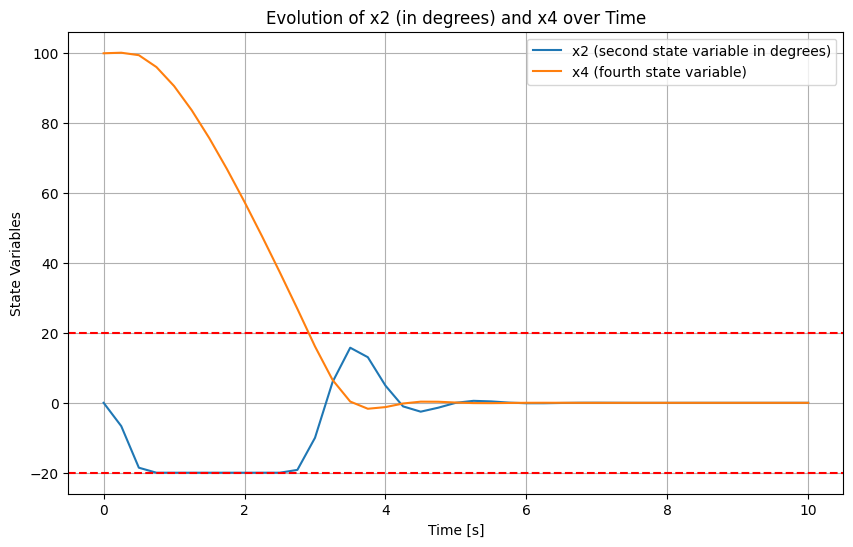

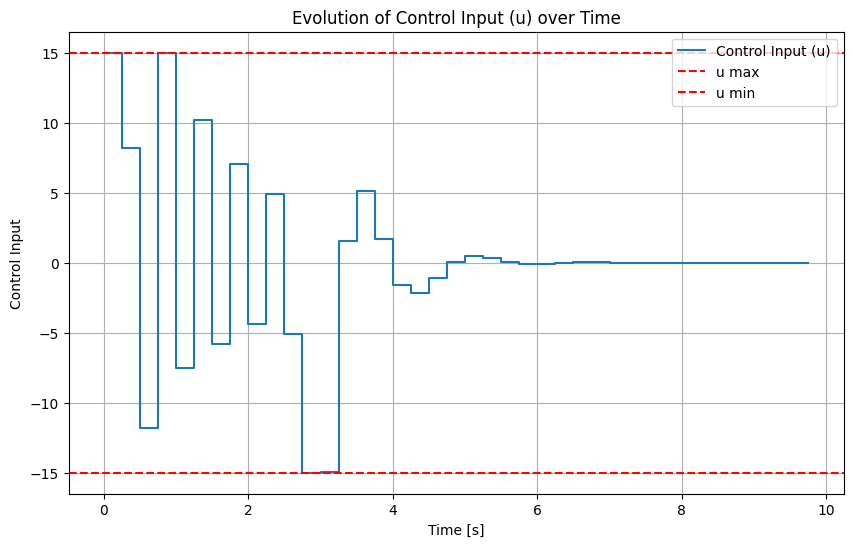

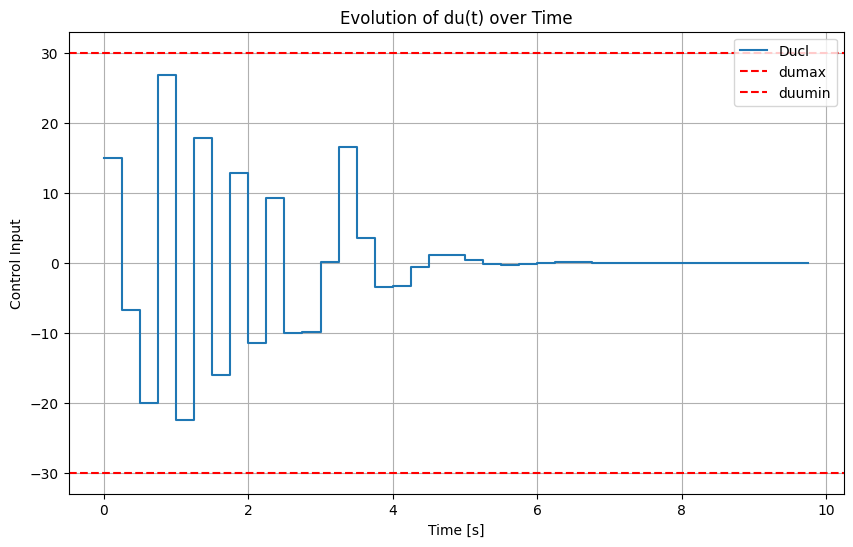

In [6]:
# Convert x2 from radians to degrees
x2_degrees = np.degrees(xcl[1, :])
x2max_degrees = np.degrees(x2max)
x2min_degrees = np.degrees(x2min)

# Plotting x2 (in degrees) and x4 
plt.figure(figsize=(10, 6))
plt.plot(t, x2_degrees, label='x2 (second state variable in degrees)')
plt.plot(t, xcl[3, :], label='x4 (fourth state variable)')
plt.axhline(x2max_degrees, color='r', linestyle='--')
plt.axhline(x2min_degrees, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('State Variables')
plt.title('Evolution of x2 (in degrees) and x4 over Time')
plt.legend()
plt.grid()
plt.show()

umax_degrees = np.degrees(umax)
umin_degrees = np.degrees(umin)
ucl_degrees = np.degrees(ucl)

# Plotting ucl
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ucl_degrees.flatten(), where='post', label='Control Input (u)')  
plt.axhline(umax_degrees, color='r', linestyle='--', label='u max')
plt.axhline(umin_degrees, color='r', linestyle='--', label='u min')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Evolution of Control Input (u) over Time')
plt.legend()
plt.grid()
plt.show()

ducl_degrees = np.degrees(ducl)
dumax_degrees = np.degrees(dumax)
dumin_degrees = np.degrees(dumin)

# Plotting ducl 
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ducl_degrees.flatten(), where='post', label='Ducl')  
plt.axhline(dumax_degrees, color='r', linestyle='--', label='dumax')
plt.axhline(dumin_degrees, color='r', linestyle='--', label='duumin')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Evolution of du(t) over Time')
plt.legend()
plt.grid()
plt.show()

## Monte-Carlo simulation

In [7]:
# Number of Monte Carlo simulations
num_simulations = 1000  

# Define ranges for initial conditions x1, x2, x3, x4
x1_range = [-0.2618, 0.2618]
x2_range = [-0.349, 0.349]  
x3_range = [-0.5, 0.5]
x4_range = [100, 100]

# Generate random initial conditions within the specified ranges
np.random.seed(42)  
x0_samples = np.zeros((num_simulations, n))
x0_samples[:, 0] = np.random.uniform(x1_range[0], x1_range[1], num_simulations)
x0_samples[:, 1] = np.random.uniform(x2_range[0], x2_range[1], num_simulations)
x0_samples[:, 2] = np.random.uniform(x3_range[0], x3_range[1], num_simulations)
x0_samples[:, 3] = np.random.uniform(x4_range[0], x4_range[1], num_simulations)




## Simulating with all the x0's

In [8]:
# Initialize lists to store data
X_data = []  # State trajectories
U_data = []  # Control inputs

for idx in range(num_simulations):
    x0 = x0_samples[idx, :]
    xcl = np.zeros((n, nsim + 1))
    xcl[:, 0] = x0
    ucl = np.zeros((m, nsim))
    ducl = np.zeros((m, nsim))
    solver = mpc.nmpc(f, l, N, x0, lb, ub, verbosity=0, isQP=True)

    success = True  

    for k in range(nsim):
        solver.fixvar("x", 0, x0)
        try:
            sol = mpc.callSolver(solver)
            print(f"Simulation {idx}, Time step {k}, Status: {sol['status']}")
            ucl[:, k] = sol["u"][0, :]
            if k > 0:
                ducl[:, k] = ucl[:, k] - ucl[:, k - 1]
            else:
                ducl[:, k] = ucl[:, k] - 0
            x0 = ffunc(x0, ucl[:, k])
            xcl[:, k + 1] = x0
        except Exception as e:
            print(f"Simulation {idx}, Time step {k}, Exception: {e}")
            print("lmao")
            success = False

    if success:
        X_data.append(xcl[:, :nsim])
        U_data.append(ucl)
        


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Simulation 0, Time step 0, Status: Succe

## Ploting x2 vs u 

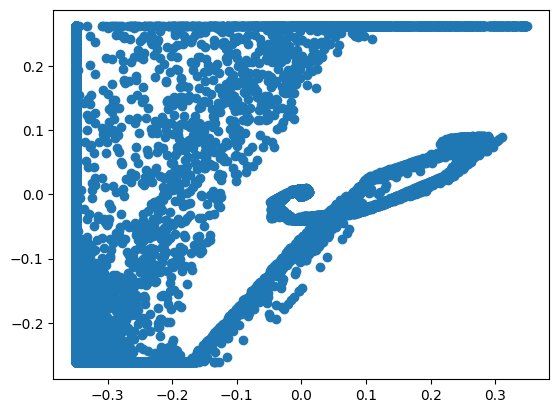

In [9]:
X_data = np.array(X_data)
U_data = np.array(U_data)

x = X_data[:, 1]  
y = U_data[:,0]

plt.scatter(x,y)
plt.show()


## Preparing the dataset

In [10]:
# Initialize lists for inputs and outputs
inputs = []
outputs = []

X_data = np.transpose(X_data, (0, 2, 1))  
U_data = np.transpose(U_data, (0, 2, 1))  

for i in range(num_simulations):
    for t in range(nsim):
        x_t = X_data[i, t, :]  # State at time t
        u_t = U_data[i, t, :]  # Control input at time t
        inputs.append(x_t)
        outputs.append(u_t)

# Convert to arrays
inputs = np.array(inputs)  
outputs = np.array(outputs)  

# Split the data
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## FeedForwardNN class

In [11]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

## Preparing data

In [12]:
# Define sequence length
seq_length = 5

# Prepare sequential data
def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length, :])
        y_seq.append(y[i+seq_length, :])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# Convert to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create datasets and dataloaders
train_seq_dataset = TensorDataset(X_train_seq_tensor, y_train_seq_tensor)
test_seq_dataset = TensorDataset(X_test_seq_tensor, y_test_seq_tensor)

train_seq_loader = DataLoader(train_seq_dataset, batch_size=batch_size, shuffle=True)
test_seq_loader = DataLoader(test_seq_dataset, batch_size=batch_size, shuffle=False)

## LSTM and LSTMSNN models

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])     
        return out

class LSTMSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMSNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        return out


## Training models

In [14]:
# Set input and output sizes
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
hidden_size = 64

# Instantiate models
model_NN = FeedforwardNN(input_size, hidden_size, output_size)
model_LSTM = LSTMModel(input_size, hidden_size, output_size)
model_LSTMSNN = LSTMSNN(input_size, hidden_size, output_size)

# Define loss function and optimizers
criterion = nn.MSELoss()
optimizer_NN = optim.Adam(model_NN.parameters(), lr=0.001)
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=0.001)
optimizer_LSTMSNN = optim.Adam(model_LSTMSNN.parameters(), lr=0.001)

def train_model(model, optimizer, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training NN-only Model")
train_model(model_NN, optimizer_NN, train_loader)

print("Training LSTM-only Model")
train_model(model_LSTM, optimizer_LSTM, train_seq_loader)

print("Training LSTMSNN Model")
train_model(model_LSTMSNN, optimizer_LSTMSNN, train_seq_loader)

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    predictions = scaler_y.inverse_transform(np.array(predictions))
    actuals = scaler_y.inverse_transform(np.array(actuals))
    mse = np.mean((predictions - actuals) ** 2)
    return mse, predictions, actuals

mse_NN, pred_NN, actual_NN = evaluate_model(model_NN, test_loader)
mse_LSTM, pred_LSTM, actual_LSTM = evaluate_model(model_LSTM, test_seq_loader)
mse_LSTMSNN, pred_LSTMSNN, actual_LSTMSNN = evaluate_model(model_LSTMSNN, test_seq_loader)

print(f"NN-only Model MSE: {mse_NN:.4f}")
print(f"LSTM-only Model MSE: {mse_LSTM:.4f}")
print(f"LSTMSNN Model MSE: {mse_LSTMSNN:.4f}")

Training NN-only Model
Epoch [5/100], Loss: 0.0018
Epoch [10/100], Loss: 0.0011
Epoch [15/100], Loss: 0.0008
Epoch [20/100], Loss: 0.0008
Epoch [25/100], Loss: 0.0007
Epoch [30/100], Loss: 0.0006
Epoch [35/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0005
Epoch [45/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0006
Epoch [55/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0004
Epoch [65/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0003
Epoch [75/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [85/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [95/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Training LSTM-only Model
Epoch [5/100], Loss: 1.0001
Epoch [10/100], Loss: 0.9995
Epoch [15/100], Loss: 0.9987
Epoch [20/100], Loss: 0.9970
Epoch [25/100], Loss: 0.9929
Epoch [30/100], Loss: 0.9846
Epoch [35/100], Loss: 0.9729
Epoch [40/100], Loss: 0.9546
Epoch [45/100], Loss: 0.9327
Epoch [50/100], Loss: 0.9075
Epoch [55/100], Loss: 0.8806
Epoch [60/100], Loss: 0.8553
Epoch [65/100], Loss: 0.8

## Simulating controller with NN 

In [17]:
def simulate_controller(model, x0, nsim):
    x = np.zeros((n, nsim + 1))
    x[:, 0] = x0
    u = np.zeros((m, nsim))
    for k in range(nsim):
        # Prepare input
        x_input = x[:, k].reshape(1, -1)
        x_input_scaled = scaler_X.transform(x_input)
        x_input_tensor = torch.tensor(x_input_scaled, dtype=torch.float32)
        # Predict control action
        with torch.no_grad():
            u_pred = model(x_input_tensor).numpy()
        u_unscaled = scaler_y.inverse_transform(u_pred)
        u[:, k] = u_unscaled
        # Apply control action
        x_next = ffunc(x[:, k], u[:, k])
        x[:, k + 1] = x_next
    return x, u

def simulate_controllerLSTM(model, x0, nsim):
    x = np.zeros((n, nsim + 1))
    x[:, 0] = x0
    u = np.zeros((m, nsim))
    for k in range(nsim):
        # Prepare input
        x_input = x[:, k].reshape(1, -1)
        x_input_scaled = scaler_X.transform(x_input)
        x_input_tensor = torch.tensor(x_input_scaled, dtype=torch.float32).unsqueeze(1) 
        # Predict control action
        with torch.no_grad():
            u_pred = model(x_input_tensor).numpy()
        u_unscaled = scaler_y.inverse_transform(u_pred)
        u[:, k] = u_unscaled
        # Apply control action
        x_next = ffunc(x[:, k], u[:, k])
        x[:, k + 1] = x_next
    return x, u

x0_test = np.array([0,0, 0, 100])
nsim_test = 40

# Simulate controllers
x_nn, u_nn = simulate_controller(model_NN, x0_test, nsim_test)
x_lstm, u_lstm = simulate_controllerLSTM(model_LSTM,x0_test,nsim_test)
x_lstmsnn, u_lstmsnn = simulate_controllerLSTM(model_LSTMSNN,x0_test,nsim_test)


## Plot results of FeedforwardNN

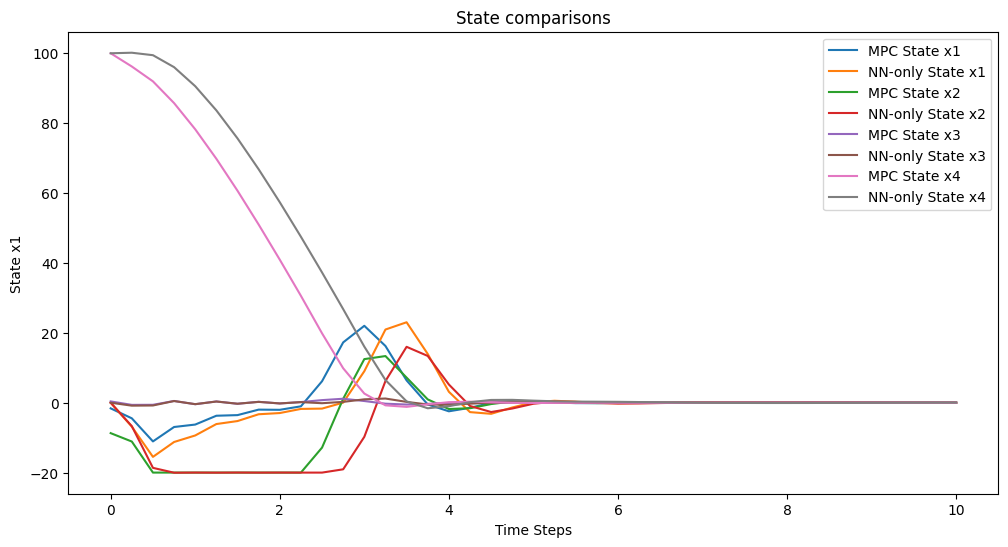

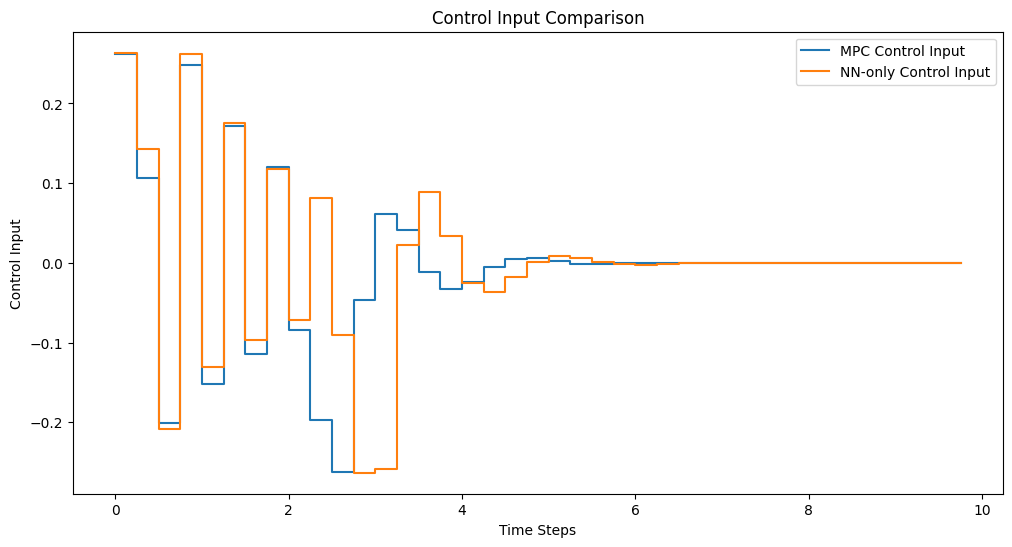

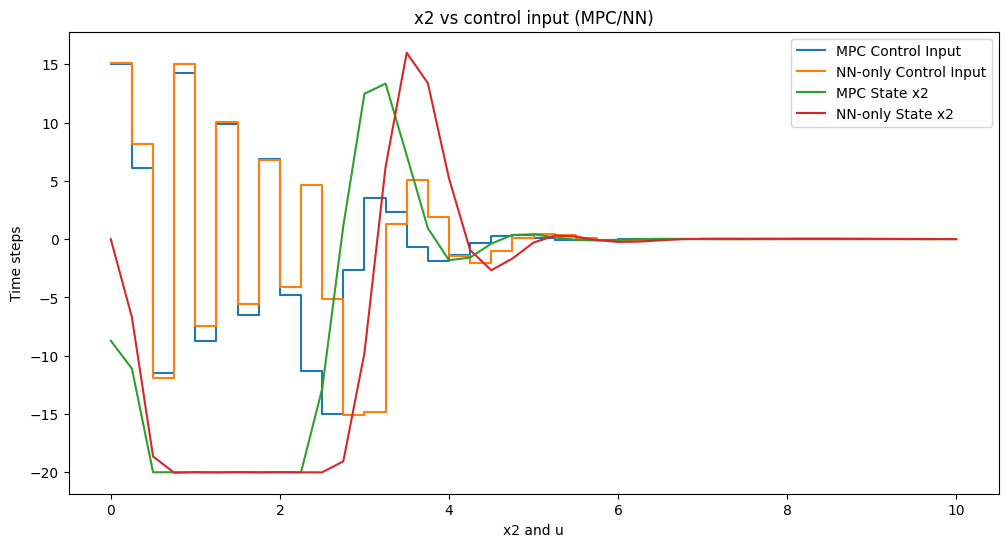

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[0, :]), label='MPC State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_nn[0, :]), label='NN-only State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_nn[1, :]), label='NN-only State x2')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[2, :], label='MPC State x3')
plt.plot(np.arange(nsim_test + 1) * dt, x_nn[2, :], label='NN-only State x3')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[3, :], label='MPC State x4')
plt.plot(np.arange(nsim_test + 1) * dt, x_nn[3, :], label='NN-only State x4')
plt.title('State comparisons')
plt.xlabel('Time Steps')
plt.ylabel('State x1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , ucl[0, :], where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , u_nn[0, :], where='post', label='NN-only Control Input')
plt.title('Control Input Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , np.degrees(ucl[0, :]), where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , np.degrees(u_nn[0, :]), where='post', label='NN-only Control Input')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_nn[1, :]), label='NN-only State x2')
plt.title('x2 vs control input (MPC/NN)')
plt.xlabel('x2 and u')
plt.ylabel('Time steps')
plt.legend()
plt.show()

## Plot results of LSTM

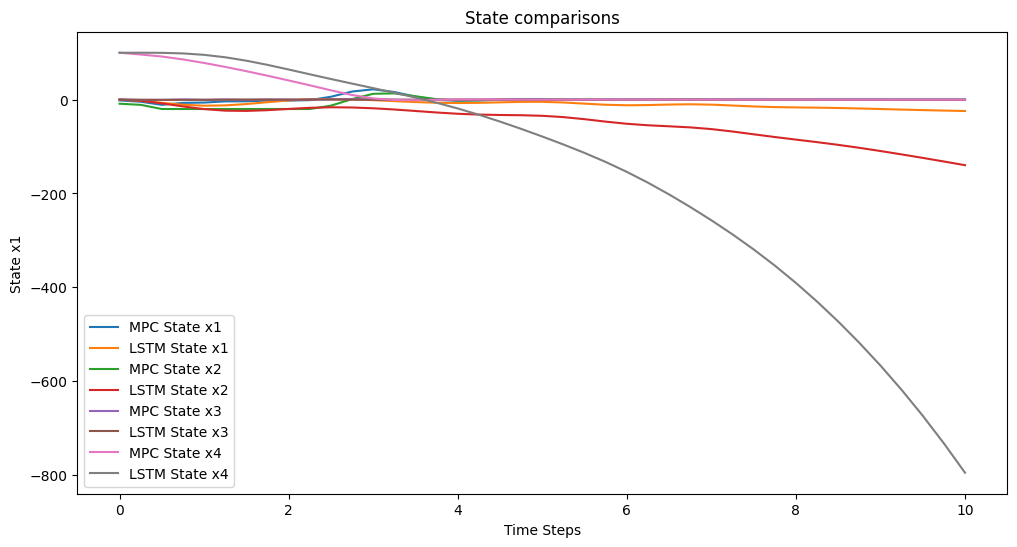

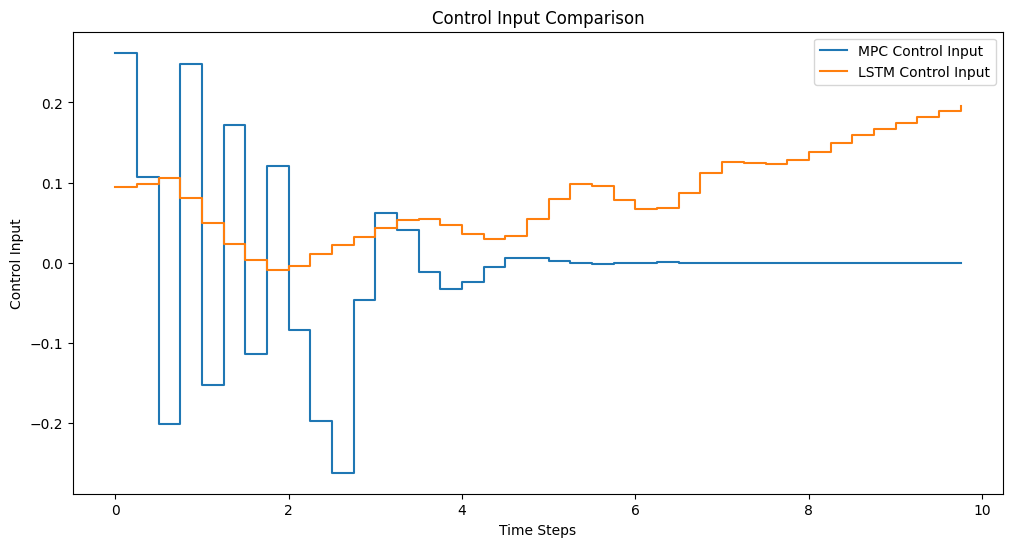

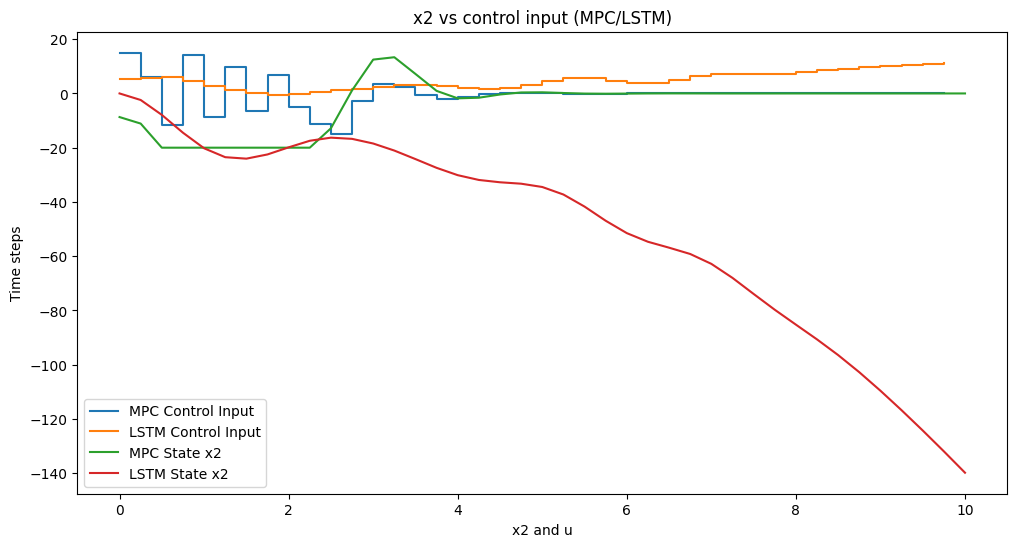

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[0, :]), label='MPC State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstm[0, :]), label='LSTM State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstm[1, :]), label='LSTM State x2')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[2, :], label='MPC State x3')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstm[2, :], label='LSTM State x3')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[3, :], label='MPC State x4')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstm[3, :], label='LSTM State x4')
plt.title('State comparisons')
plt.xlabel('Time Steps')
plt.ylabel('State x1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , ucl[0, :], where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , u_lstm[0, :], where='post', label='LSTM Control Input')
plt.title('Control Input Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , np.degrees(ucl[0, :]), where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , np.degrees(u_lstm[0, :]), where='post', label='LSTM Control Input')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstm[1, :]), label='LSTM State x2')
plt.title('x2 vs control input (MPC/LSTM)')
plt.xlabel('x2 and u')
plt.ylabel('Time steps')
plt.legend()
plt.show()

## Plot results of LSTMNN

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[0, :]), label='MPC State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstmsnn[0, :]), label='LSTMNN State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstmsnn[1, :]), label='LSTMNN State x2')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[2, :], label='MPC State x3')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstmsnn[2, :], label='LSTMNN State x3')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[3, :], label='MPC State x4')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstmsnn[3, :], label='LSTMNN State x4')
plt.title('State comparisons')
plt.xlabel('Time Steps')
plt.ylabel('State x1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , ucl[0, :], where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , u_lstmsnn[0, :], where='post', label='LSTMNN Control Input')
plt.title('Control Input Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , np.degrees(ucl[0, :]), where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , np.degrees(u_lstmsnn[0, :]), where='post', label='LSTMNN Control Input')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstmsnn[1, :]), label='LSTMNN State x2')
plt.title('x2 vs control input (LSTMNN)')
plt.xlabel('x2 and u')
plt.ylabel('Time steps')
plt.legend()
plt.show()